Let's start by importing the libraries we'll need

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

Let's limit Pandas to 2 decimal places.

In [63]:
pd.options.display.float_format = '{:,.2f}'.format

Now let's read the data

In [64]:
df = pd.read_csv("fep.csv")
df.head()

,Target,ID,Experimental_dG,FEP_dG,TI_dG
0,bace,bace_12,-8.53,-6.76,-8.27
1,bace,bace_30,-7.84,-7.40,-7.40
2,bace,bace_29,-9.01,-7.93,-7.80
3,bace,bace_28,-8.25,-7.01,-9.72
4,bace,bace_27,-9.10,-10.14,-10.16


I find it easier to deal with data as pIC50 rather than $\Delta$G, so we'll convert the $\Delta$G to a pIC50. We'll calculate the experimental pI50, the calculated pIc50, and the fold error. 

In [65]:
df['Experimental_pIC50'] = [-math.log10(math.exp(x / 0.5961)) for x in df.Experimental_dG]
df['FEP_pIC50'] = [-math.log10(math.exp(x / 0.5961)) for x in df.FEP_dG]
df['Fold_Error'] = 10**abs(df.Experimental_pIC50-df.FEP_pIC50)

Let's look at the data frame again to ensure that it makes sense.

In [66]:
df.head()

,Target,ID,Experimental_dG,FEP_dG,TI_dG,Experimental_pIC50,FEP_pIC50,Fold_Error
0,bace,bace_12,-8.53,-6.76,-8.27,6.21,4.93,19.48
1,bace,bace_30,-7.84,-7.40,-7.40,5.71,5.39,2.09
2,bace,bace_29,-9.01,-7.93,-7.80,6.56,5.78,6.12
3,bace,bace_28,-8.25,-7.01,-9.72,6.01,5.11,8.01
4,bace,bace_27,-9.10,-10.14,-10.16,6.63,7.39,5.72


Let's bin the fold error into <5 fold, 5-10 fold, and >10 fold

In [67]:
df["Error"]=pd.cut(df.Fold_Error,bins=[0,5,10,1e6],labels=["<5","5-10",">10"])

In [68]:
df.head()

,Target,ID,Experimental_dG,FEP_dG,TI_dG,Experimental_pIC50,FEP_pIC50,Fold_Error,Error
0,bace,bace_12,-8.53,-6.76,-8.27,6.21,4.93,19.48,>10
1,bace,bace_30,-7.84,-7.40,-7.40,5.71,5.39,2.09,<5
2,bace,bace_29,-9.01,-7.93,-7.80,6.56,5.78,6.12,5-10
3,bace,bace_28,-8.25,-7.01,-9.72,6.01,5.11,8.01,5-10
4,bace,bace_27,-9.10,-10.14,-10.16,6.63,7.39,5.72,5-10


Ok, now that we have our data in shape we can make some plots. First off, let's set up some of the plot aesthetics.

In [69]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set(style="whitegrid",font_scale=1.5)

Python doesn't provide an easy way to make a dynamite plot, but that's ok because those a terrible anyway.  The Seaborn library does provide the ability to plot a barplot with errorbars. 

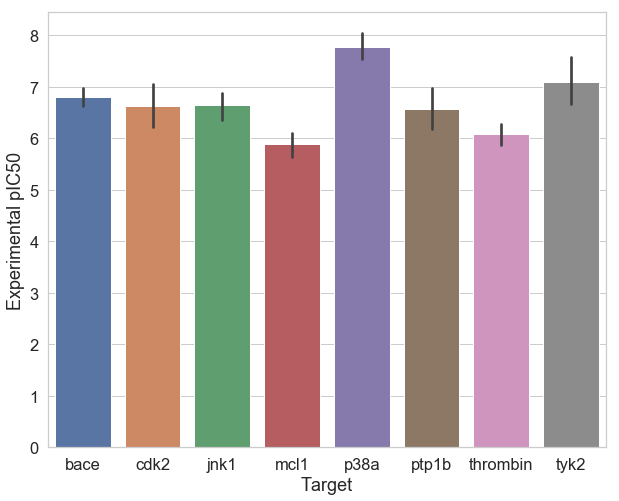

In [70]:
ax = sns.barplot(x="Target",y="Experimental_pIC50",data=df)
_ = ax.set(ylabel="Experimental pIC50")

This plot doesn't provide a lot of information.  It just shows the mean and the standard deviation.  In order to be more informative, we'll make a box plot. 

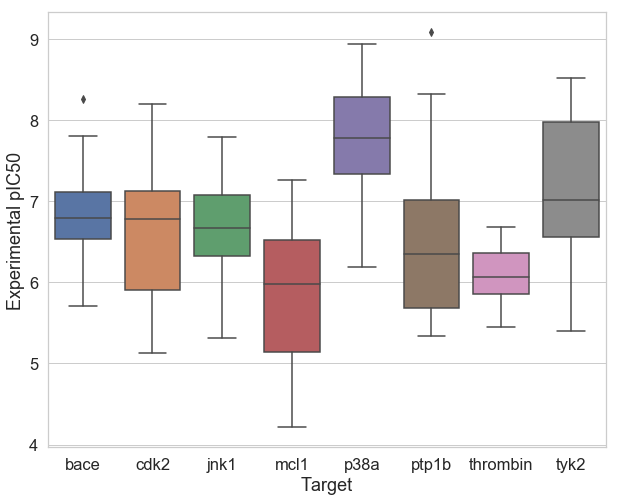

In [71]:
ax = sns.boxplot(x="Target",y="Experimental_pIC50",data=df)
_ = ax.set(ylabel="Experimental pIC50")

As an alternative to a box plot we can make a beeswarm plot where we color the data by the error bin we calculated above. 

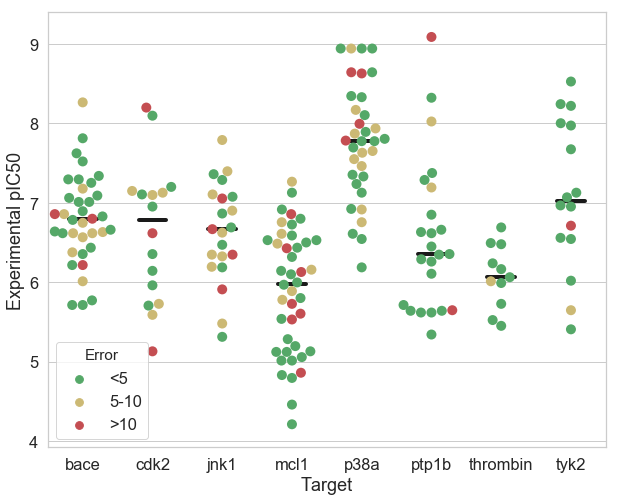

In [74]:
ax = sns.swarmplot(x="Target",y="Experimental_pIC50",hue="Error",
                   data=df,palette=["g","y","r"],s=10)
# draw lines at the median, taken from 
# https://stackoverflow.com/questions/37619952/drawing-points-with-with-median-lines-in-seaborn-using-stripplot
median_width = 0.4
for tick, text in zip(ax.get_xticks(), ax.get_xticklabels()):
    sample_name = text.get_text()  # "X" or "Y"
    res = df.query(f"Target == '{sample_name}'")
    # calculate the median value for all replicates of either X or Y
    median_val = np.median(res.Experimental_pIC50)
    # plot horizontal lines across the column, centered on the tick
    ax.plot([tick-median_width/2, tick+median_width/2], [median_val, median_val],lw=4, color='k')
_ = ax.set(ylabel="Experimental pIC50")


In order to better appreciate the shapes of the distributions, we can make a violin plot.

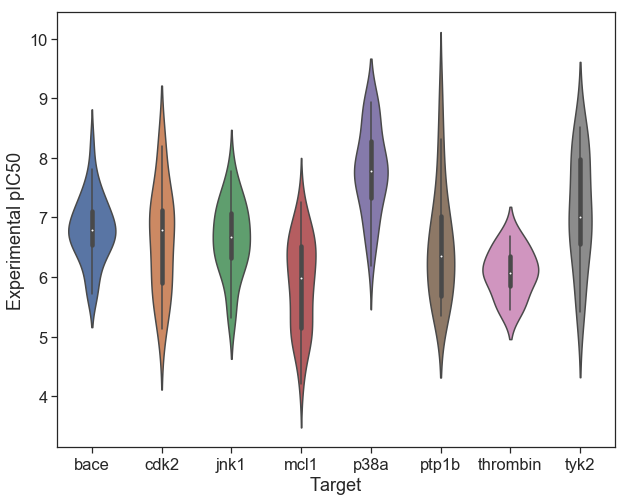

In [32]:
sns.set(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)},font_scale=1.5)
ax = sns.violinplot(x="Target",y="Experimental_pIC50",data=df)
_ = ax.set(ylabel="Experimental pIC50")

Another approach to plotting distributions is the ridge plot.  This on is a bit more tricky, and it takes a bit of work to get the plot to look the way you want it to.  The example below was pretty much taken from a [Seaborn example](https://seaborn.pydata.org/examples/kde_ridgeplot.html)

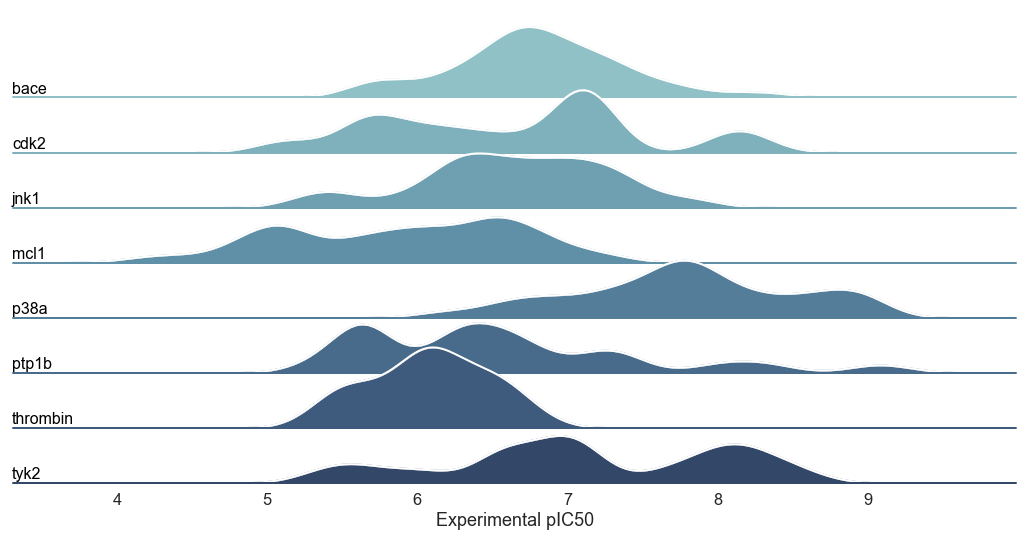

In [33]:
def label(x, color, label):
    ax = plt.gca()
    ax.text(3.3,0.05,label,color="black",fontsize=16)

# set up the plot aesthetics
sns.set(rc={'figure.figsize':(10,8)})
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)},font_scale=1.5)
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)

# set up the facet grid
g = sns.FacetGrid(df, row="Target", hue="Target", aspect=15, height=1, palette=pal)

# plot the kde plots
g.map(sns.kdeplot,"Experimental_pIC50",clip_on=True,shade=True,alpha=1,lw=1.5,bw=0.2)
g.map(sns.kdeplot, "Experimental_pIC50", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# put the target names on the plots
g.map(label,"Target")

# a bunch of fiddling to make the plots pretty
g.despine(bottom=True, left=True)
g.fig.subplots_adjust(hspace=-0.35)
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
_ = g.axes[-1][0].set_xlabel("Experimental pIC50")